In [2]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
import os

In [3]:
load_dotenv()

llm = ChatGroq(
    groq_api_key=os.getenv("GROQ_API_KEY"),
    model_name="openai/gpt-oss-120b"
)


In [5]:
class ParentState(TypedDict):

    question: str
    ans_eng: str
    ans_hin: str

In [6]:
def translate_text(state: ParentState):

    prompt = f"""
Translate the following text to Hindi.
Keep it natural and clear. Do not add extra content.

Text:
{state["ans_eng"]}
""".strip()
    
    translated_text = llm.invoke(prompt).content

    return {'ans_hin': translated_text}

In [7]:
sub_graph = StateGraph(ParentState)

sub_graph.add_node('translate_text', translate_text)

sub_graph.add_edge(START, 'translate_text')
sub_graph.add_edge('translate_text', END)

subgraph = sub_graph.compile()

In [8]:
def generate_answer(state: ParentState):

    answer = llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'ans_eng': answer}

In [9]:
graph = StateGraph(ParentState)

graph.add_node("answer", generate_answer)
graph.add_node("translate", subgraph)

graph.add_edge(START, 'answer')
graph.add_edge('answer', 'translate')
graph.add_edge('translate', END)
workflow = graph.compile()

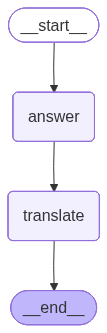

In [10]:
workflow

In [11]:
workflow.invoke({"question":"What is LangGraph?"})

{'question': 'What is LangGraph?',
 'ans_eng': '**LangGraph** is an open‑source Python library (part of the LangChain ecosystem) that makes it easy to build **state‑ful, graph‑structured applications powered by large language models (LLMs)**.  \n\n---\n\n## Core Idea\nInstead of writing a linear chain of prompts, you describe a **directed graph** where each node is a *step* (a prompt, a tool call, a conditional branch, etc.) and edges define how control flows from one step to the next based on the **state** that is carried along the execution.\n\n| Concept | What it is | Why it matters |\n|---------|------------|----------------|\n| **Node** | A callable unit (prompt template, tool, function, sub‑graph, etc.) | Encapsulates a single piece of logic. |\n| **Edge** | A transition rule that decides the next node | Enables branching, loops, retries, and dynamic routing. |\n| **State** | A mutable dictionary (or any serialisable object) that persists across nodes | Allows you to keep context